In [21]:
try:
    import os
    import glob
    import pandas as pd

    import matplotlib.pyplot as plt
    import numpy as np

    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

except Exception as e:
    print(f"Error : {e}")

In [22]:
# Find the CSV file in the Datasets directory
data_path = '../Datasets/*.csv'
file_list = glob.glob(data_path)

for file in file_list:
    print(f"Found file: {file}")

# Ensure there is exactly one file
if len(file_list) == 1:
    # Load the dataset
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

Found file: ../Datasets/Dataset.csv
Loaded dataset: ../Datasets/Dataset.csv


In [23]:
# File path to save the trained model
destination = '../Models/'
os.makedirs(destination, exist_ok=True)
print(f"Model will be saved to: {destination}")

Model will be saved to: ../Models/


In [24]:
# Separate features for encoding
onehot_features = ['microstructure', 'seedLocation', 'castType']
label_features = ['partType']
encoder = "Hybrid Encoding"

# Custom transformers
label_encoder = LabelEncoder()
df['partType'] = label_encoder.fit_transform(df['partType'])  # Apply label encoding directly

# Create a ColumnTransformer for One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        # To match the output of One-Hot Encoding with the Label Encoding
        ('onehot', OneHotEncoder(dtype=int), onehot_features)
    ],
    remainder='passthrough'  # Keeps all other features as they are
)

# Define pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        max_depth=15,
        n_estimators=387,
        random_state=42
    ))
])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Lifespan']), df['Lifespan'], test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)

print(f"--- Performance of {encoder} ---\n")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSLE: {msle:.2f}")

--- Performance of Hybrid Encoding ---

RMSE: 89.61
R² Score: 0.92
MAE: 71.38
MSLE: 0.01


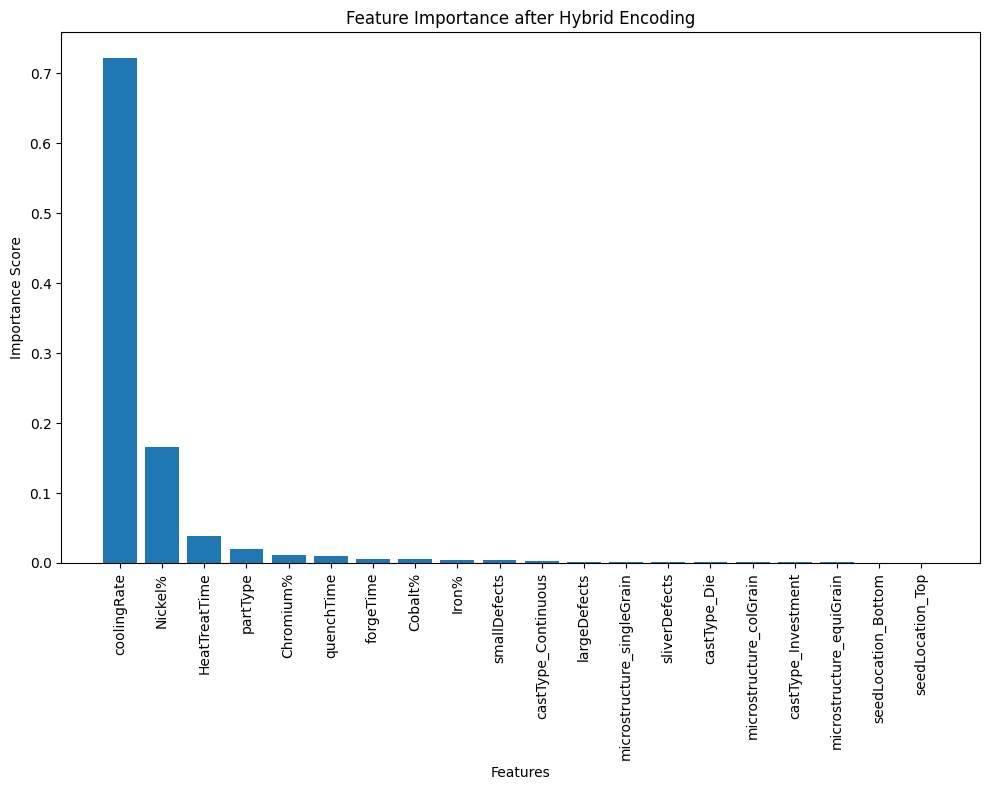

In [25]:
# Step 1: Access the trained Random Forest model from the pipeline
rf_model_imp = pipeline.named_steps['model']

# Step 2: Retrieve the feature names from the preprocessor
# Get the One-Hot Encoder categories and append label encoded features
onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['onehot']
onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_features)

# Combine One-Hot Encoded feature names with label-encoded and numerical feature names
all_feature_names = list(onehot_feature_names) + label_features + [col for col in X_train.columns if col not in onehot_features + label_features]

# Step 3: Extract the feature importances from the RandomForestRegressor
importances = rf_model_imp.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Step 4: Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importance after Hybrid Encoding")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(all_feature_names)[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [26]:
# Important features
important_features = ['partType', 'coolingRate', 'Nickel%', 'HeatTreatTime', 'Chromium%' , 'quenchTime']

# Subset the dataset to include only the important features
X_important = df[important_features]

# Split the dataset
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_important, df['Lifespan'], test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor with the best parameters obtained from previous tuning
rf_model_imp = RandomForestRegressor(
    max_depth=15,
    n_estimators=387,
    random_state=42
)

# Train the model with reduced features
rf_model_imp.fit(X_train_imp, y_train_imp)

# Evaluate the model
y_pred_imp = rf_model_imp.predict(X_test_imp)
rmse_imp = root_mean_squared_error(y_test_imp, y_pred_imp)
r2_imp = r2_score(y_test_imp, y_pred_imp)
mae_imp = mean_absolute_error(y_test_imp, y_pred_imp)
msle_imp = mean_squared_log_error(y_test_imp, y_pred_imp)

print(f"--- Performance of {encoder} ---\n")
print(f"Reduced Features RMSE: {rmse_imp:.2f}")
print(f"Reduced Features R² Score: {r2_imp:.2f}")
print(f"Reduced Features MAE: {mae_imp:.2f}")
print(f"Reduced Features MSLE: {msle_imp:.2f}")

--- Performance of Hybrid Encoding ---

Reduced Features RMSE: 84.17
Reduced Features R² Score: 0.93
Reduced Features MAE: 66.48
Reduced Features MSLE: 0.01
